# Generate High-Resolution Spectral Maps with Contour Binning

Using [Jeremy Sanders' contour binning code](https://github.com/jeremysanders/contbin), we’re going to make high-resolution spectral maps of A2597’s ICM! This method adaptively bins the data based on surface brightness, ensuring each region has enough counts for reliable spectral fitting while preserving spatial structure. This will give us detailed maps of temperature, density, pressure, abundance, and entropy across the cluster.

In [1]:
#paths
path_to_chandra = '/Users/osaseomoruyi/Dropbox (Harvard University)/Abell_2597/analysis/ChandraA2597/'
git_path = '/Users/osaseomoruyi/github_repos/chandraA2597/'
#path to all abell 2597 data
path_to_a2597 = path_to_chandra[:-13]

In [2]:
import os
import re
import glob
import shutil
import logging

import warnings
warnings.filterwarnings("ignore")

import json

import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


from astropy.io import fits
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
import pyregion
from astropy.wcs import WCS
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord


#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import LogNorm


# Run CIAO within Python! 
import ciao_contrib.runtool as ciao
from sherpa.astro import ui as sherpa

In [3]:
# Run CIAO within Python! 
import ciao_contrib.runtool as ciao
from sherpa.astro import ui as sherpa

#### Abell2597-specific parameters
These will be used throughout the Notebook.

In [4]:
#About Abell 2597
obsids = [ # '922', # 922 is in FAINT mode and has a terrible flare, let's just ditch it
          '6934', # 56.0 ksec, Clarke ACIS-S3 VFAINT
          '7329', # 60.11 ksec, Clarke ACIS-S3 VFAINT
          '19596', # 69.39 ksec, Tremblay ACIS S3 VFAINT
          '19597', # 44.52
          '19598', # 14.34
          '20626', # 24.73
          '20627', # 20.85
          '20628', # 10.92
          '20629', # 56.36
          '20805', # 53.4
          '20806', # 37.62
          '20811', # 79.85
          '20817'] # 62.29

name = 'Abell 2597'
rah, decd = '23h25m19.7s', '-12d07m27s'
coord = SkyCoord(rah, decd, frame='icrs')
ra = coord.ra.degree
dec = coord.dec.degree
radius = Angle(20, u.arcsec)

z = 0.0821
zh = 0.0821
nH = 2.252e+20 # % (HI4PI)   DL,LAB: 2.500e+20 2.515e+20
kT_guess = 4.0 # keV
abundance_guess = 0.4
r500 = 904.8 # kpc This is R_500_Y from Vikhlinin et al.
r500_err = 2.4 #
m500 = 2.279e14 # Msol This is M_500_Y from Vikhlinin et al.
m500_err = 1.797e12

acis_pixel_scale = 0.4920 * u.arcsec


cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
angular_diameter_distance = cosmo.angular_diameter_distance(z=z) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, the angular diameter distance is {np.round(angular_diameter_distance,4)}')
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.0821, the angular diameter distance is 318.8353 Mpc
At a redshift of 0.0821, we have 1.5458 kpc / arcsec


Define some functions

In [5]:

# Use custom function for patch attribute
def pyregion_color(shape, saved_attrs):
    attr_list, attr_dict = saved_attrs
    attr_dict["color"] = "green"
    kwargs = pyregion.mpl_helper.properties_func_default(shape, (attr_list, attr_dict))

    return kwargs

def show_img(fits_image, regions=None):

    cmap = plt.cm.magma
    cmap.set_bad('black')
    
    fig, ax = plt.subplots(figsize=(10,10))
    imgdata = fits.getdata(fits_image)
    imhdr = fits.getheader(fits_image)
    ax.imshow(imgdata, origin='lower', cmap='magma', norm=LogNorm())

    if regions is not None:
        for region in regions:
            r = pyregion.open(region).as_imagecoord(imhdr)
            patch_list, artist_list = r.get_mpl_patches_texts(pyregion_color)

            for p in patch_list:
                ax.add_patch(p)
            for t in artist_list:
                ax.add_artist(t)


### Important Paths

In [6]:
starting_dir = '/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/'
data_dir = starting_dir + 'joint_analysis/'
region_dir = starting_dir + 'regions/'

#the new directory to save the spectral maps
working_dir = os.path.join(starting_dir) + 'spectral_maps/'

if not os.path.exists(working_dir):
    os.makedirs(working_dir)
    print(f'Made directory {working_dir}')
else:
    print(f'Directory {working_dir} already exists')

os.chdir(working_dir)

print(f'Now working in direcotry {os.getcwd()}')

Directory /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/ already exists
Now working in direcotry /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps


### Data has already been downloaded an reprocessed to the joint_analysis directory 
no need to duplicate if you followed notebook 1

In [7]:
data_dir = starting_dir + 'joint_analysis/'
region_dir = starting_dir + 'regions/'

os.getcwd()

'/Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps'


Establish the directory structure...

In [11]:
new_run = False
contour_binning_directory = os.path.join(working_dir, 'contour_binning/')
if not os.path.exists(contour_binning_directory):
    os.makedirs(contour_binning_directory)
    print(f'Made directory {contour_binning_directory}')

else:
    print(f'Directory {contour_binning_directory} already exists')

    if new_run is True:
        # Clean up existing files that conflict with this run name
        existing_run_files = glob.glob(f'{contour_binning_directory}/*')
        for f in existing_run_files:
            os.remove(f)
        print(f'Removed all existing files from {contour_binning_directory}')

os.chdir(contour_binning_directory)

Directory /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/ already exists


In [10]:
os.chdir(data_dir)
necessary_files = ['broad_thresh.img', # the cliped counts image for binning
                    'broad_thresh_bgndsubtract.img', # the cliped counts image for binning with background usbtracted
                   'broad_thresh.expmap', # the exposure map for the image
                   'broad_flux.img', # the original flux image
                   'merged_evt.fits' # the merged event file
                   ]

for item in necessary_files:
    shutil.copyfile(item, os.path.join(contour_binning_directory, item))
    print(f'Copied {item} to {contour_binning_directory}')

os.chdir(region_dir)
necessary_files = ['omo_wavedetect_src.reg', # the region file for the deteted sources
                   ]

for item in necessary_files:
    shutil.copyfile(item, os.path.join(contour_binning_directory, item))
    print(f'Copied {item} to {contour_binning_directory}')

Copied broad_thresh.img to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/
Copied broad_thresh_bgndsubtract.img to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/
Copied broad_thresh.expmap to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/
Copied broad_flux.img to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/
Copied merged_evt.fits to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/
Copied omo_wavedetect_src.reg to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/


In [11]:
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.0821, we have 1.5458 kpc / arcsec


We want our maps to cover beyond the outermost "cocoon shock", so we will make maps of the central 200 arcsec

In [13]:
lss_radius = 200 * u.arcsec

Open DS9, and make a circular region (centered on the cluster center) with the different radii

Afterwards, let's move them over

In [13]:
new_region_files = ['lss_region.reg' # large scale structure region
                   ]

os.chdir(region_dir)
for item in new_region_files:
    shutil.copyfile(item, os.path.join(contour_binning_directory, item))
    print(f'Copied {item} to {contour_binning_directory}')

Copied lss_region.reg to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/


#### STOP!!!!! Make sure you see the correct region!

In [14]:
os.chdir(contour_binning_directory)

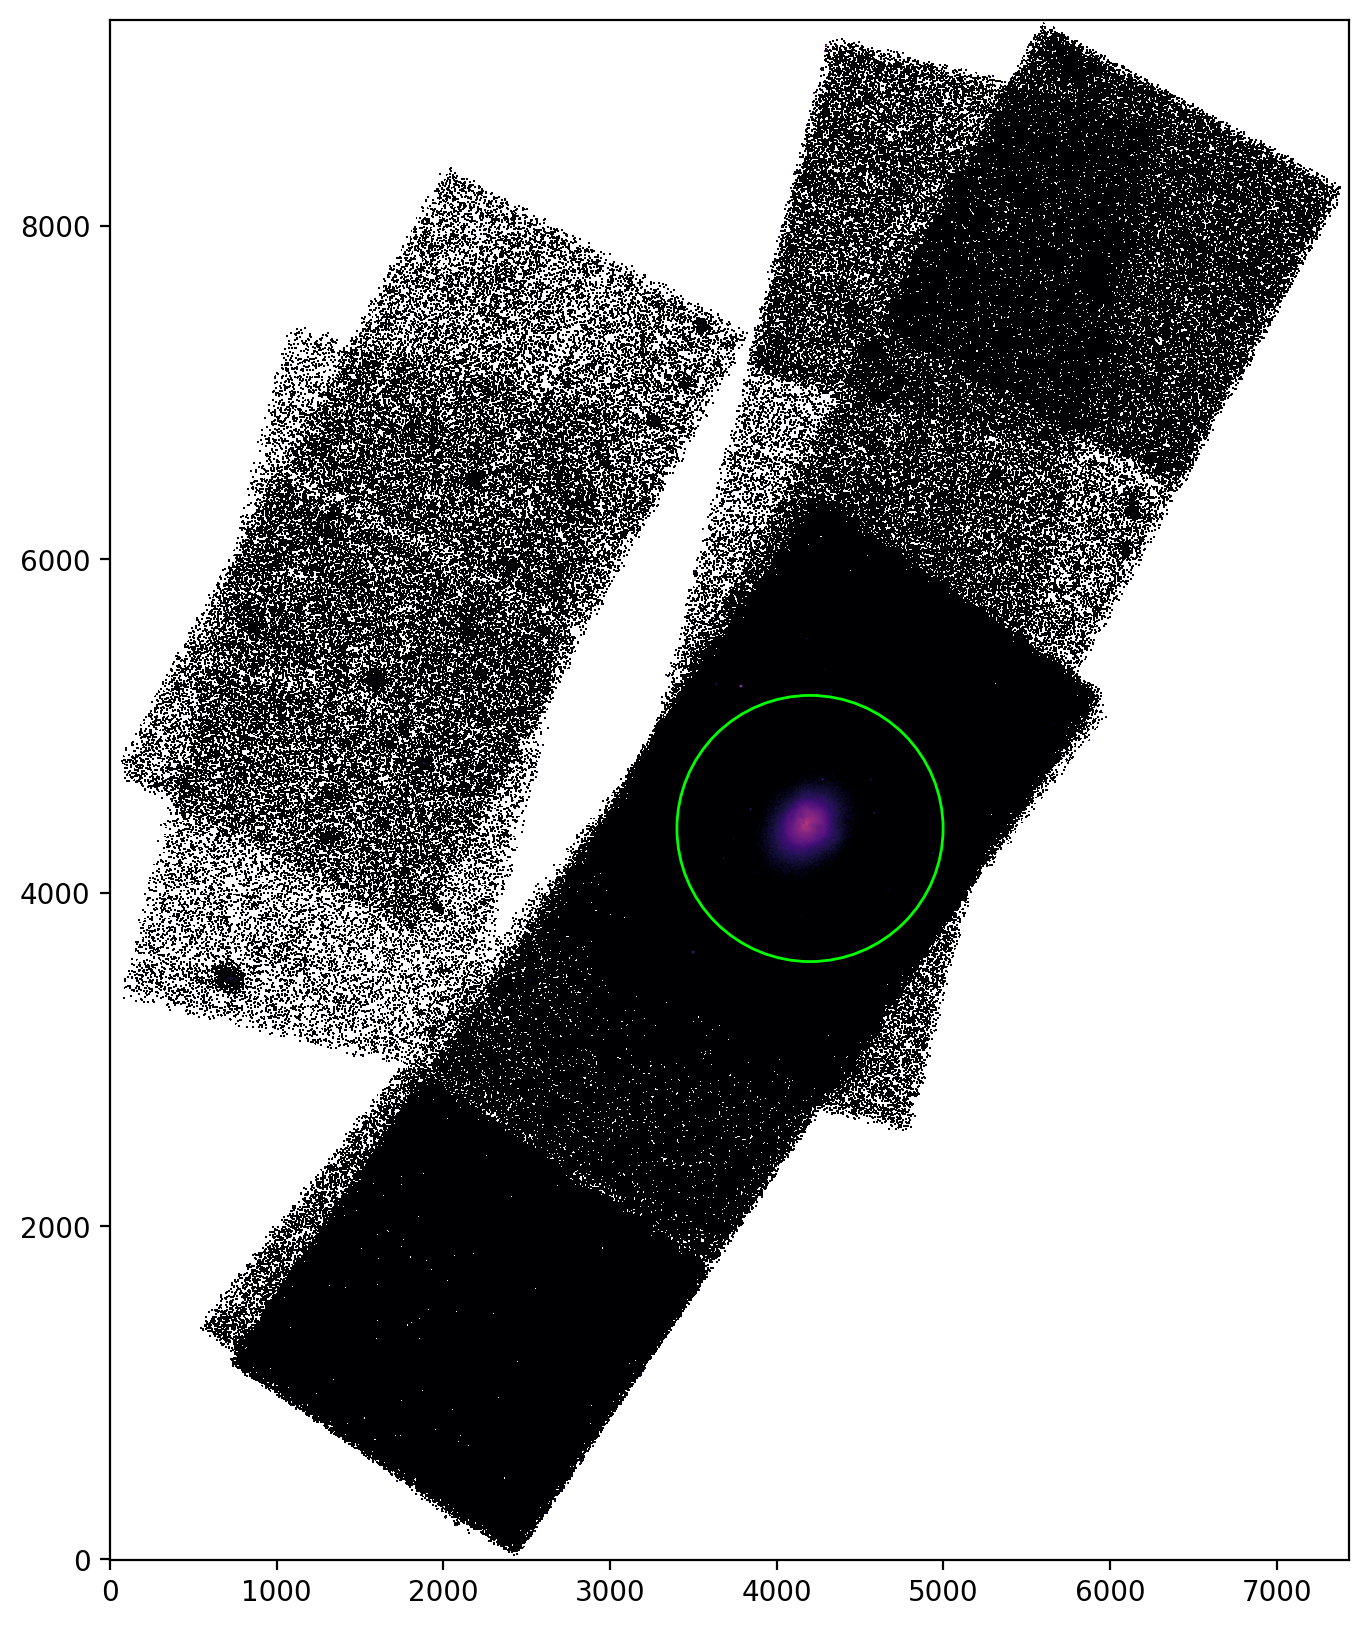

In [16]:
show_img('broad_flux.img', regions=['lss_region.reg'])

We must crop the image to just outside the region to avoid this process taking 84787948 years

In [17]:
for region in new_region_files:
    print(f'Working on {region}')
    os.system(f"dmcopy 'broad_thresh.img' full_contbin_input_{region.replace('.reg', '')}.fits clobber=yes")
    os.system(f"dmcopy 'full_contbin_input_lss_region.fits[bin x=3600:4500:1, y=3600:4500:1]' contbin_input_{region.replace('.reg', '')}.fits clobber=yes")
    print(f"Created {contour_binning_directory}contbin_input_{region.replace('.reg', '')}.fits")


Created /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/contour_binning/contbin_input_lss_region.fits


In [18]:
cropped_images = glob.glob('contbin_input_*.fits')
cropped_images

['contbin_input_lss_region.fits']

### Time to Mask Point Sources to be Excluded from Contour Binning

We need to create a mask where **0s mark good pixels** and **1s mark bad pixels** to exclude point sources from contour binning.   

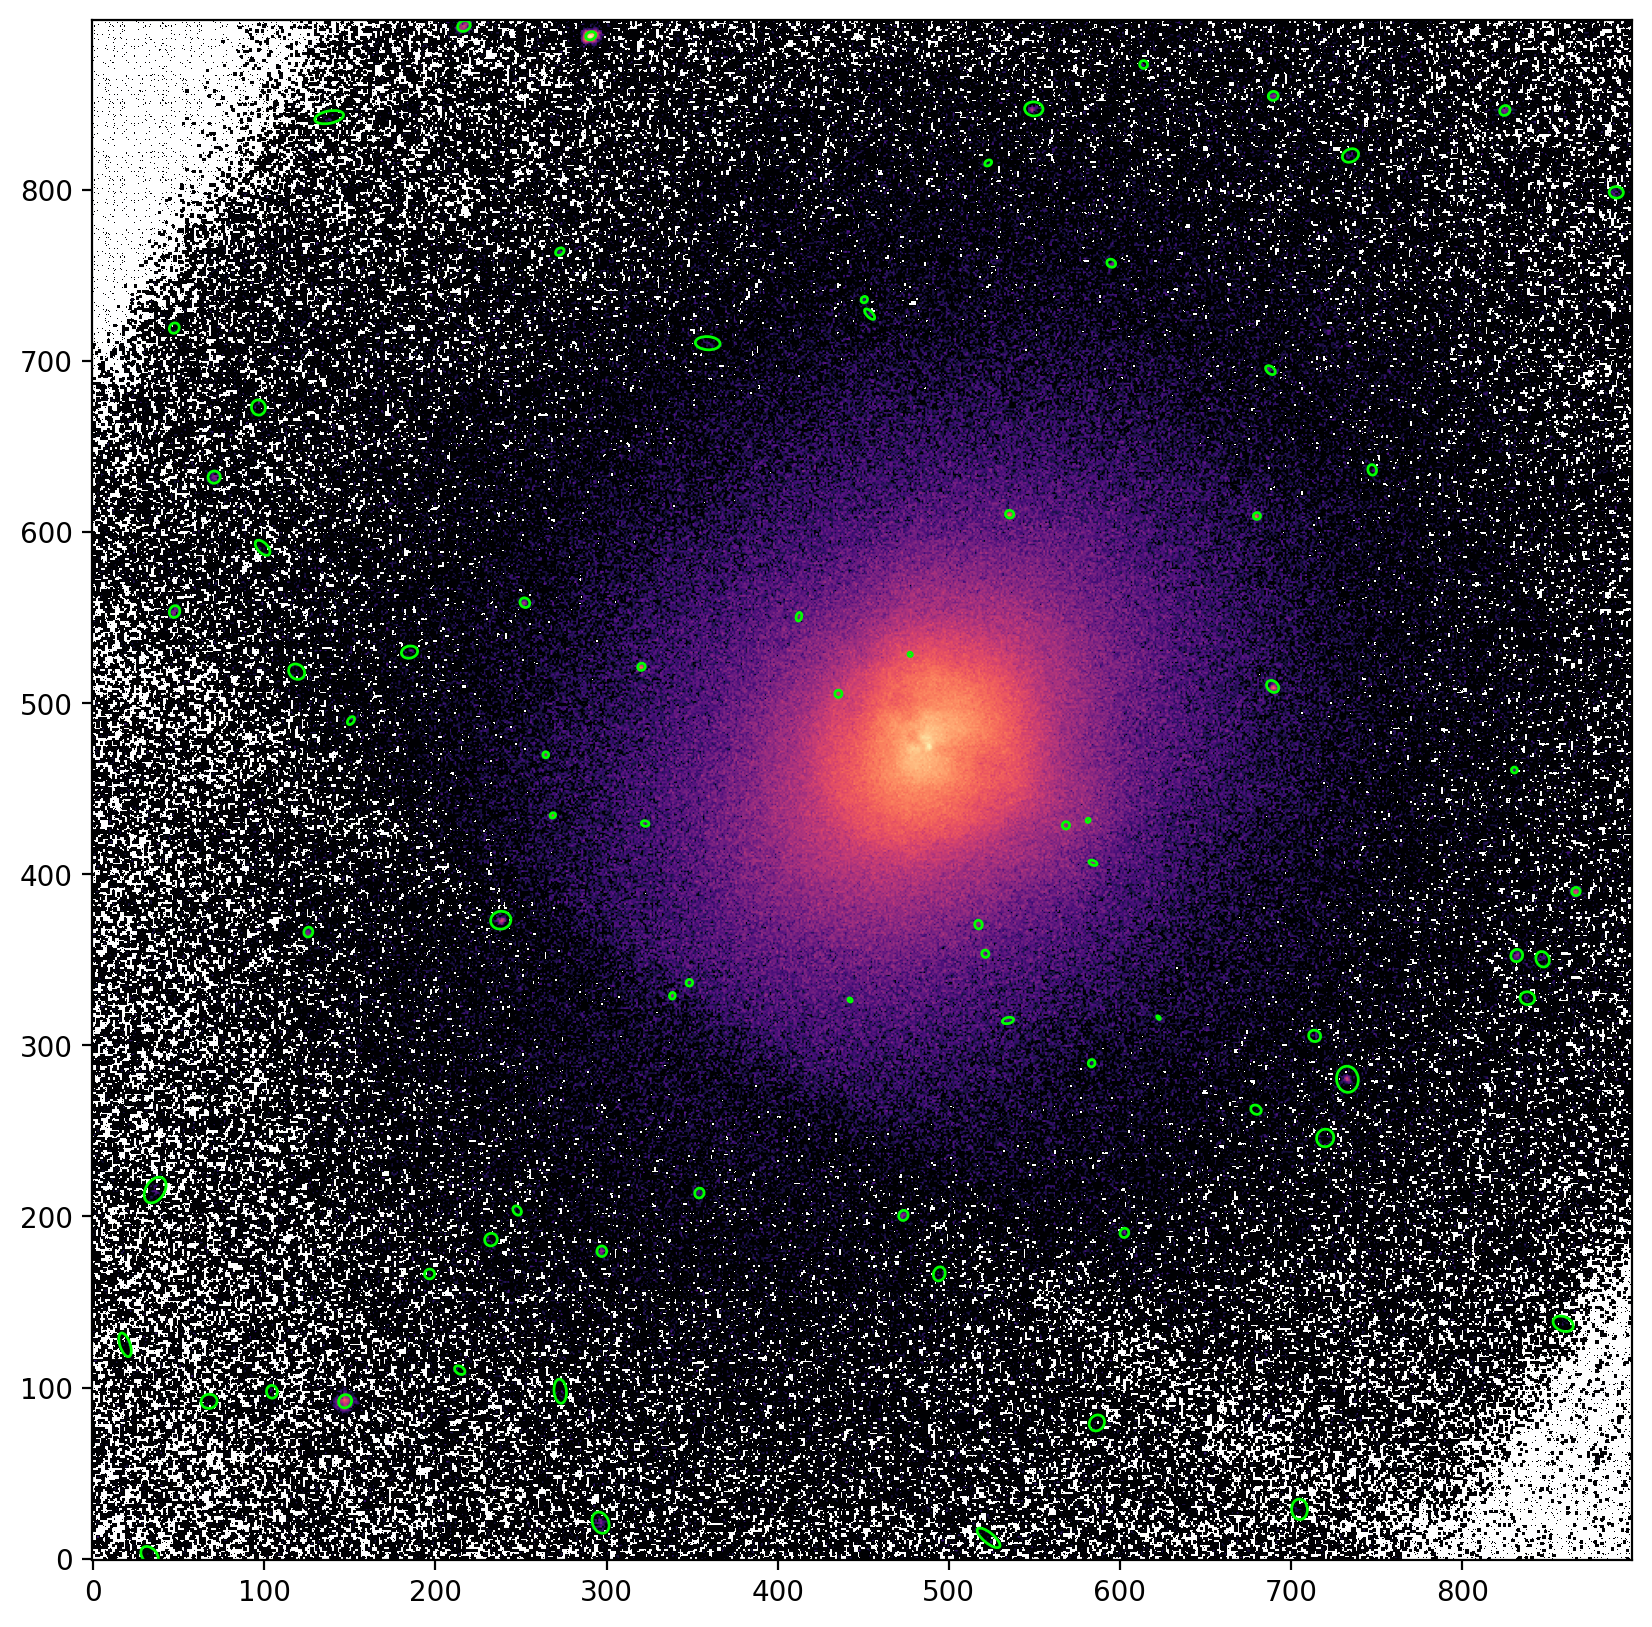

In [19]:
#plot sources identified by wavdetect
show_img(cropped_images[0], regions=['omo_wavedetect_src.reg'])

In [20]:
for cropped_image in cropped_images:
    os.system(f'dmimgcalc "{cropped_image}" op="imgout=img1*0" out="allzeros_{cropped_image}" mode=h clobber=yes')
    os.system(f'dmimgcalc "allzeros_{cropped_image}" op="imgout=img1+1" out="allones_{cropped_image}" mode=h clobber=yes')
    os.system(f'dmcopy "allones_{cropped_image}[exclude sky=region(omo_wavedetect_src.reg)]" binary_mask_{cropped_image} clobber=yes')


crop the masks as well or else contbin takes 84 years

In [26]:
for idc, cropped_image in enumerate(cropped_images):
    os.system(f'dmcopy "binary_mask_{cropped_image}[bin x=3600:4500:1, y=3600:4500:1]" binary_mask_cropped_{cropped_image} clobber=yes')


Failed to open virtual file contbin_input_lss_region.fits[bin x=3600:4500:1,3600:4500:1]
# dmcopy (CIAO 4.16.0): DM error: attempt to bin on unknown identifier 3600:4500:1


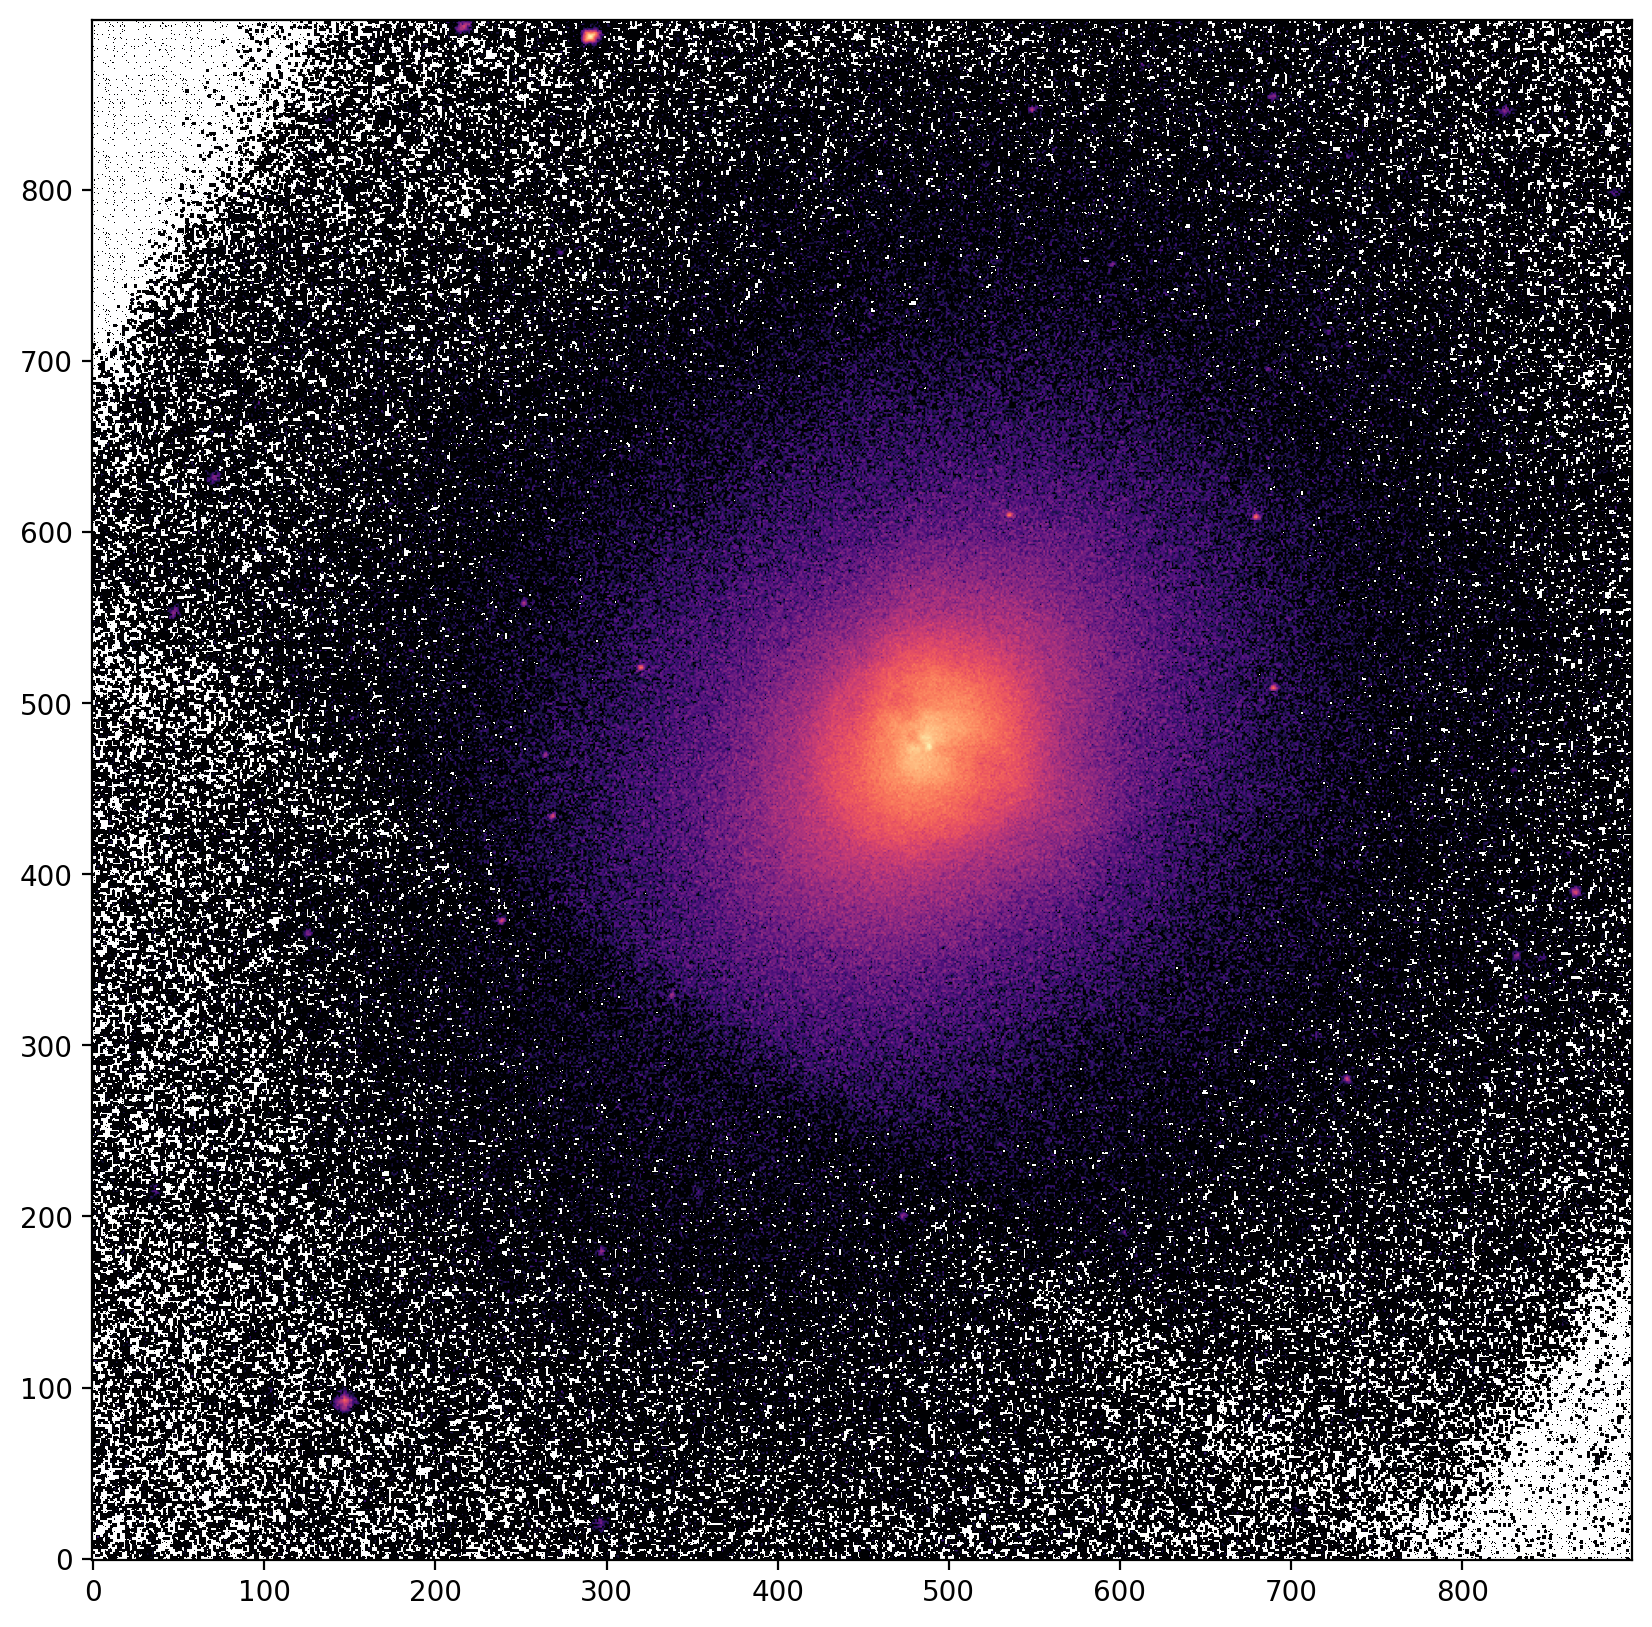

In [30]:
#plot contbin maps
for idc, cropped_image in enumerate(cropped_images):
    show_img(f'{cropped_image}')

#show_img('contbin_out50_nomask_constrain3_smooth30.fits')

### Now let's (finally!) create contour binning maps

In [28]:
#terms for the binning
sn = 30 # 30**2 counts per bin
smoothsn = 15 # Signal to noise to smooth the image by before binning.
constrainval = 2 # so bins look compact not spaghetti-like

In [29]:
for idc, cropped_image in enumerate(cropped_images):

    print('***************************************')
    print(f'Working on {cropped_image}')
    print('***************************************')

    os.system(f'contbin --outbinmap=contbin_out{sn}_constrain{constrainval}_smooth{smoothsn}_{cropped_images[idc][14:-5]}.fits \
              --sn={sn} --smoothsn={smoothsn}  --mask=binary_mask_cropped_contbin_input_{cropped_images[idc][14:-5]}.fits\
              --constrainfill --constrainval={constrainval} {cropped_image}')
    

***************************************
Working on contbin_input_lss_region.fits
***************************************
(i) Loading image contbin_input_lss_region.fits
Opening contbin_input_lss_region.fits (RO)
Reading image (900x900)
(i) Loading masking image binary_mask_cropped_contbin_input_lss_region.fits
Opening binary_mask_cropped_contbin_input_lss_region.fits (RO)
Reading image (900x900)
Closing binary_mask_cropped_contbin_input_lss_region.fits
(i) Using blank foreground exposure (exp=583820)
(i) Using blank background exposure (exp=1)
(i) Smoothing data (S/N = 15)
    99.9%
(i) Sorting pixels, binning from top... Done.
(i) Starting binning
   10    20    30    40    50    60    70    80    90   100  [0.1%]
  110   120   130   140   150   160   170   180   190   200  [0.2%]
  210   220   230   240   250   260   270   280   290   300  [0.4%]
  310   320   330   340   350   360   370   380   390   400  [0.5%]
  410   420   430   440   450   460   470   480   490   500  [0.7%]
  5

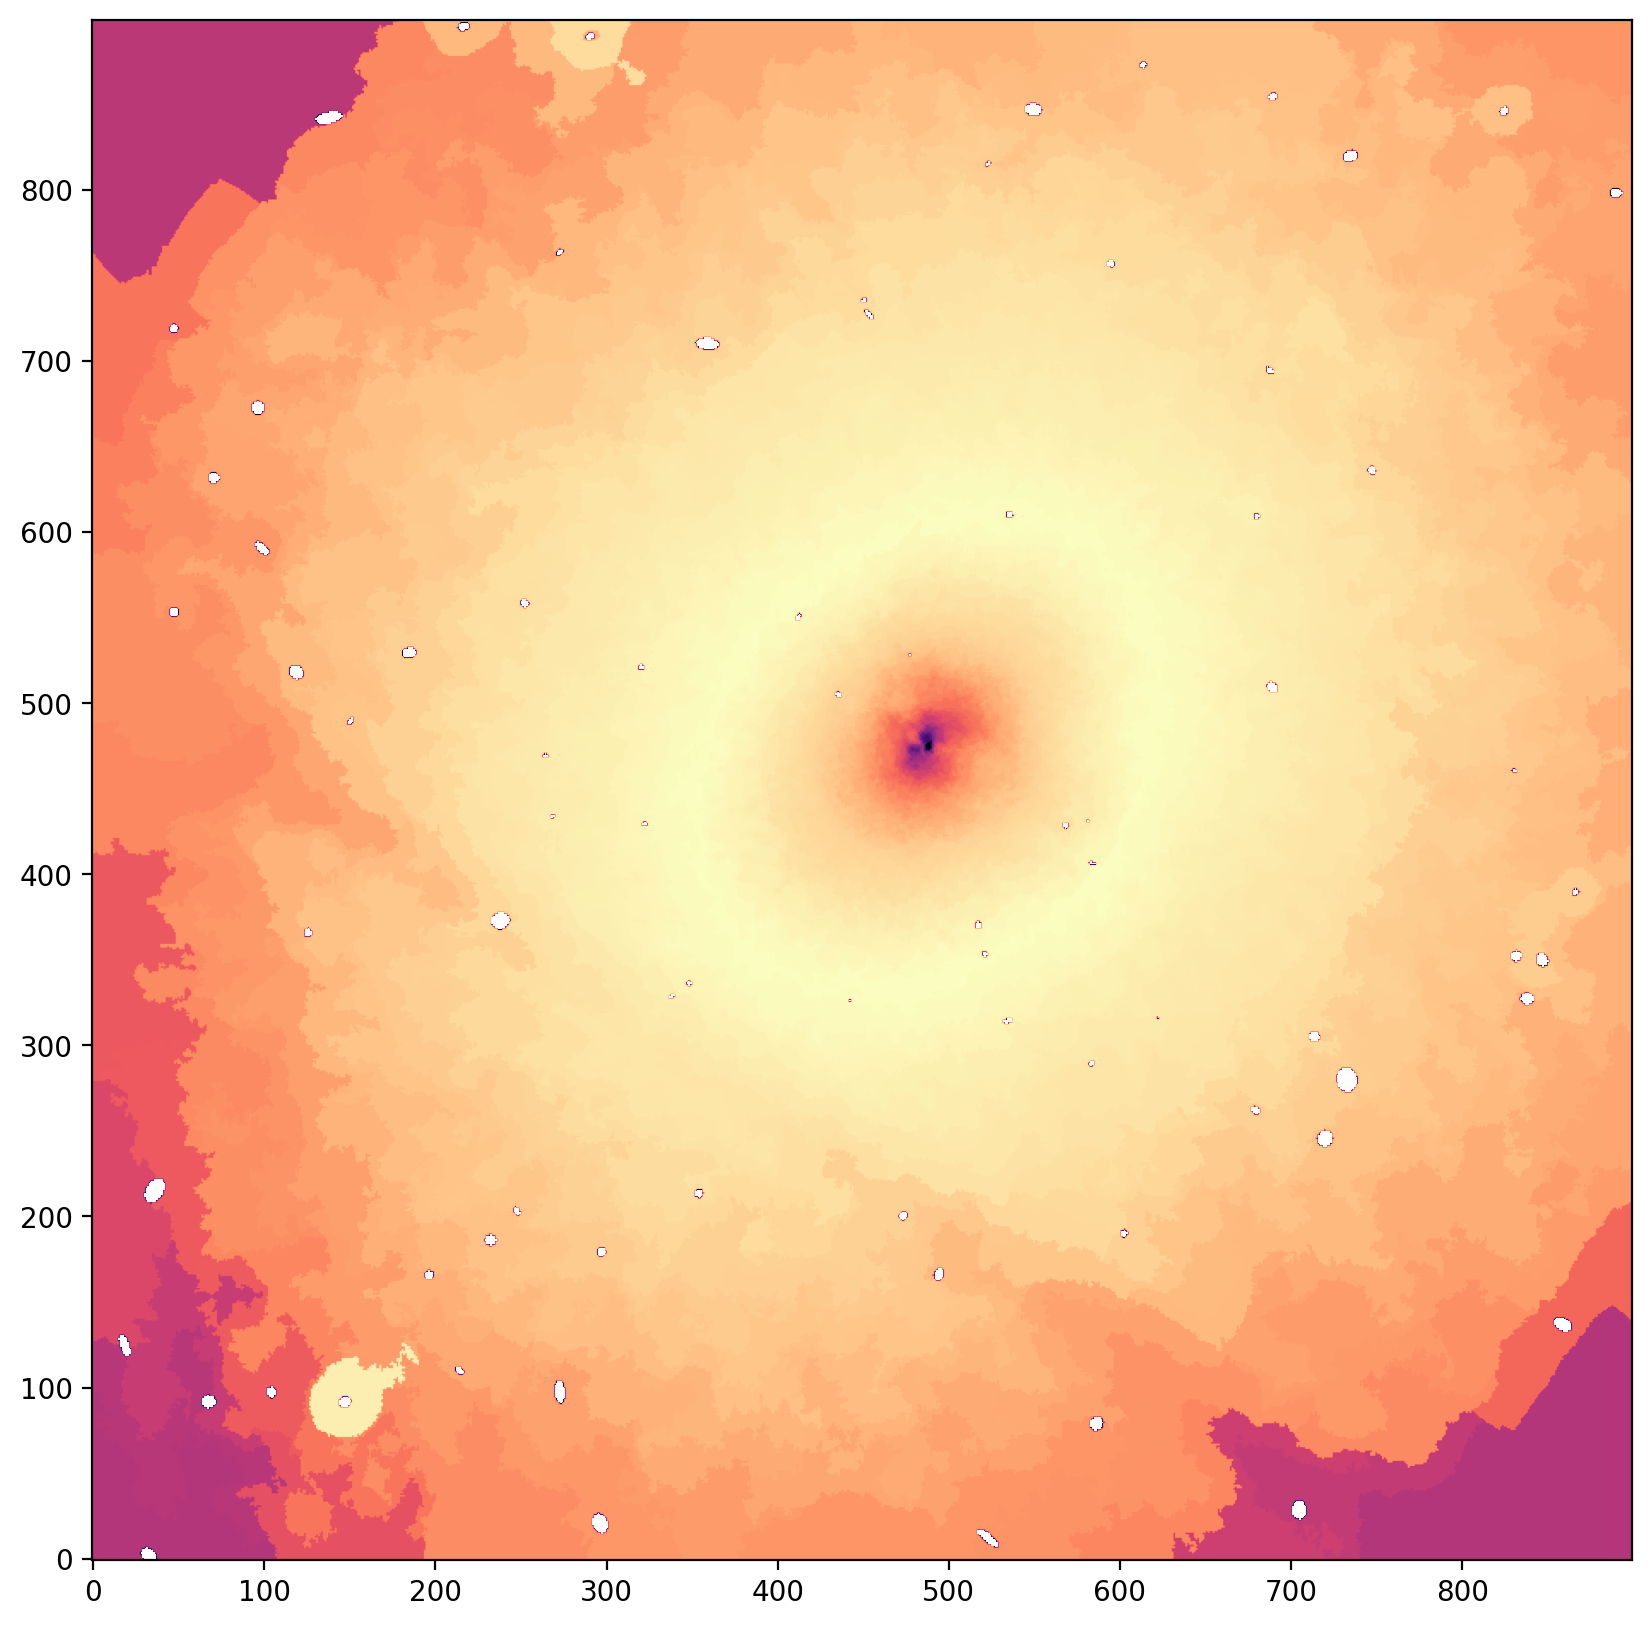

In [30]:
#plot contbin maps
for idc, cropped_image in enumerate(cropped_images):
    show_img(f'contbin_out{sn}_constrain{constrainval}_smooth{smoothsn}_{cropped_image[14:-4]}fits')

#show_img('contbin_out50_nomask_constrain3_smooth30.fits')

### Let's prepare for spectral fitting!

In [31]:
contbin_maps = glob.glob(f'contbin_out*constrain{constrainval}*.fits')
print(contbin_maps)

['contbin_out30_constrain2_smooth15_lss_region.fits']


In [32]:
#create directory for spectral fitting
spectral_fitting_dirs = []
date = '022424'

for contbin_map in contbin_maps:

    cname = contbin_map[11:-5]
    spectral_fitting_dir = os.path.join(working_dir, f'spectral_maps_{date}_{cname}/')
    spectral_fitting_dirs.append(spectral_fitting_dir)

    if not os.path.exists(spectral_fitting_dir):
        os.makedirs(spectral_fitting_dir)
        print(f'Made directory {spectral_fitting_dir}')

    else:
        print(f'Directory {spectral_fitting_dir} already exists')



Made directory /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/spectral_maps_022424_30_constrain2_smooth15_lss_region/


#### Create regions to extract spectra from based on bins

In [33]:
def remove_region_files():
    for f in glob.glob("xaf*.reg"):
        os.remove(f)

In [35]:
for ids, spectral_fitting_dir in enumerate(spectral_fitting_dirs):

    os.chdir(contour_binning_directory)
    item = contbin_maps[ids]
    shutil.copyfile(item, os.path.join(spectral_fitting_dir, item))
    os.chdir(spectral_fitting_dir)
    binning_factor = 1
    reg_name = spectral_fitting_dir[118:-1]
    contbin_output = glob.glob(f'*{sn}*constrain{constrainval}*{reg_name}*')[0]
    print(f'contbin_output is {contbin_output}')
    print(contbin_output)

    remove_region_files()

    os.system(f'''
            make_region_files --minx=3600 --miny=3600 --bin={binning_factor} contbin_out{sn}_constrain{constrainval}_smooth{smoothsn}_{cropped_image[14:-4]}fits
            ''')


contbin_output is contbin_out30_constrain2_smooth15_lss_region.fits
contbin_out30_constrain2_smooth15_lss_region.fits
Input binmap: contbin_out30_constrain2_smooth15_lss_region.fits
Output directory: .
Minimum x: 3600
Minimum y: 3600
Binning factor: 1
Opening contbin_out30_constrain2_smooth15_lss_region.fits (RO)
Reading image (900x900)
Closing contbin_out30_constrain2_smooth15_lss_region.fits
Bin 0 (./xaf_0.reg)
Bin 1 (./xaf_1.reg)
Bin 2 (./xaf_2.reg)
Bin 3 (./xaf_3.reg)
Bin 4 (./xaf_4.reg)
Bin 5 (./xaf_5.reg)
Bin 6 (./xaf_6.reg)
Bin 7 (./xaf_7.reg)
Bin 8 (./xaf_8.reg)
Bin 9 (./xaf_9.reg)
Bin 10 (./xaf_10.reg)
Bin 11 (./xaf_11.reg)
Bin 12 (./xaf_12.reg)
Bin 13 (./xaf_13.reg)
Bin 14 (./xaf_14.reg)
Bin 15 (./xaf_15.reg)
Bin 16 (./xaf_16.reg)
Bin 17 (./xaf_17.reg)
Bin 18 (./xaf_18.reg)
Bin 19 (./xaf_19.reg)
Bin 20 (./xaf_20.reg)
Bin 21 (./xaf_21.reg)
Bin 22 (./xaf_22.reg)
Bin 23 (./xaf_23.reg)
Bin 24 (./xaf_24.reg)
Bin 25 (./xaf_25.reg)
Bin 26 (./xaf_26.reg)
Bin 27 (./xaf_27.reg)
Bin 28 

##### STOP!!! Chekc the location of the regions in ds9 with:

ds9 file.fits -cmap Magma -regions load all '*.reg'

In [36]:
os.system(f'''
        ds9 contbin_out{sn}_constrain{constrainval}_smooth{smoothsn}_{cropped_image[14:-4]}fits -cmap Magma -regions load all 'xaf*.reg'
        ''')

Fontconfig warning: ignoring UTF-8: not a valid region tag


0

In [37]:
new_spectral_dir = True

for ids, spectral_fitting_dir in enumerate(spectral_fitting_dirs):

    os.chdir(working_dir)

    required_ancillary_files = ['_repro_bpix1.fits', '_000N001_asol1.fits', '_repro_fov1.fits', '_repro_flt2.fits', '_000N0*_msk1.fits']

    for obsid in obsids:
        source = os.path.join(data_dir, f'{obsid}_repro_flarecleaned_evt2.fits')
        dest = os.path.join(spectral_fitting_dir, f'{obsid}_repro_flarecleaned_evt2.fits')
        shutil.copy(source, dest)
        print(f'Copied {source} to {dest}')

        source = os.path.join(data_dir, f'{obsid}_blanksky_evt.fits')
        dest = os.path.join(spectral_fitting_dir, f'{obsid}_blanksky_evt.fits')
        shutil.copy(source, dest)

        for item in required_ancillary_files:
            source=glob.glob(os.path.join(data_dir, f'*{obsid+item}'))[0]
            dest=os.path.join(spectral_fitting_dir, source.split('/')[-1])
            shutil.copy(source, dest)
            print(f'Copied {source} to {dest}')


    other_stuff_we_need = [contbin_output, starting_dir + 'scripts/extract_contbin_spectra.py', starting_dir + 'scripts/create_spectral_maps_noabundance.py',
                           starting_dir + 'scripts/fit_contbin_spectra_noabundance.py', starting_dir + 'scripts/fit_contbin_spectra.py',
                           starting_dir + 'scripts/create_spectral_maps.py'] #['fit_regions.py', 'extract_spectra.py', contbin_output]#, 'contbin_out_old_cropped.fits']

    for stuff in other_stuff_we_need:
        source = os.path.join(contour_binning_directory, stuff)
        dest = os.path.join(spectral_fitting_dir, stuff)
        shutil.copy(source, dest)



Copied /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/6934_repro_flarecleaned_evt2.fits to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/spectral_maps_022424_30_constrain2_smooth15_lss_region/6934_repro_flarecleaned_evt2.fits
Copied /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/6934_repro_bpix1.fits to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/spectral_maps_022424_30_constrain2_smooth15_lss_region/6934_repro_bpix1.fits
Copied /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/pcadf06934_000N001_asol1.fits to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/spectral_maps_022424_30_constrain2_smooth15_lss_region/pcadf06934_000N001_asol1.fits
Copied /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/joint_analysis/6934_repro_fov1.fits to /Users/osaseomoruyi/research/a2597/chandra/careful_analysis/spectral_maps/spectr

To avoid issues with spectral extraction, we need to convert the regions to FK5 format in CIAO. There is no easy way to do this, however, so let's do it in python

In [38]:
os.chdir(spectral_fitting_dir)

In [39]:
#convert ciao physical rgeions created to ds9 wcs
region_list = glob.glob('xaf*.reg') 

for idr, region in enumerate(region_list):
    print(f"Converting region: #{idr + 1}/{len(region_list)}")
    os.system(f"regphystocel {region} ds9_{region} wcsfile={contbin_output}")

Converting region: #1/1789
regphystocel
          infile = xaf_1783.reg
         outfile = ds9_xaf_1783.reg
         wcsfile = contbin_out30_constrain2_smooth15_lss_region.fits
            text = 
             tag = 
         clobber = no
         verbose = 1
            mode = ql

Converting region: #2/1789
regphystocel
          infile = xaf_157.reg
         outfile = ds9_xaf_157.reg
         wcsfile = contbin_out30_constrain2_smooth15_lss_region.fits
            text = 
             tag = 
         clobber = no
         verbose = 1
            mode = ql

Converting region: #3/1789
regphystocel
          infile = xaf_631.reg
         outfile = ds9_xaf_631.reg
         wcsfile = contbin_out30_constrain2_smooth15_lss_region.fits
            text = 
             tag = 
         clobber = no
         verbose = 1
            mode = ql

Converting region: #4/1789
regphystocel
          infile = xaf_625.reg
         outfile = ds9_xaf_625.reg
         wcsfile = contbin_out30_constrain2_smoot

In [40]:
def convert_ds9_to_ciao_wcs(sample_reg):
    """ 
    Convert a ds9 region file to a CIAO region file with WCS coordinates

    """
    with open(sample_reg, 'r') as f:
        lines = f.readlines()
        lines_to_edit = lines[3:]

    new_region  = ""
    for input_string in lines_to_edit:

        # input_string = lines_to_edit[0]

        # Use regex to extract all floating-point numbers
        numbers = re.findall(r"\d+\.\d+", input_string)

        #we want the last two
        xbox, ybox = float(numbers[-2]), float(numbers[-1])

        #convert to arcminutes
        xbox_arcmin, ybox_arcmin = xbox / 60, ybox / 60


        string_parts = input_string.split(",")

        new_string = f"{string_parts[0]},{string_parts[1]},{xbox_arcmin}',{ybox_arcmin}',0)\n"

        new_region += new_string

    save_region_file = "ciao_" + sample_reg[4:] #"my_region.reg"

    # Write the string to the file
    with open(save_region_file, "w") as file:
        file.write(new_region) 

    print (f"Saved new region file as {save_region_file}")

In [41]:
ds9_region_list = glob.glob('ds9*xaf*.reg') 

for idr, region in enumerate(ds9_region_list):
    print(f"Converting region: #{idr + 1}/{len(ds9_region_list)}")
    convert_ds9_to_ciao_wcs(region)

Converting region: #1/1789
Saved new region file as ciao_xaf_1379.reg
Converting region: #2/1789
Saved new region file as ciao_xaf_913.reg
Converting region: #3/1789
Saved new region file as ciao_xaf_907.reg
Converting region: #4/1789
Saved new region file as ciao_xaf_1345.reg
Converting region: #5/1789
Saved new region file as ciao_xaf_1423.reg
Converting region: #6/1789
Saved new region file as ciao_xaf_1437.reg
Converting region: #7/1789
Saved new region file as ciao_xaf_1351.reg
Converting region: #8/1789
Saved new region file as ciao_xaf_708.reg
Converting region: #9/1789
Saved new region file as ciao_xaf_1386.reg
Converting region: #10/1789
Saved new region file as ciao_xaf_734.reg
Converting region: #11/1789
Saved new region file as ciao_xaf_720.reg
Converting region: #12/1789
Saved new region file as ciao_xaf_1392.reg
Converting region: #13/1789
Saved new region file as ciao_xaf_1609.reg
Converting region: #14/1789
Saved new region file as ciao_xaf_1621.reg
Converting region: #

#### STOP!!!! Make sure the regions are in the correct place!!!!

In [42]:
os.system(f'''
        ds9 20817_repro_flarecleaned_evt2.fits -cmap Magma -regions load all 'ciao*.reg'
        ''')

Fontconfig warning: ignoring UTF-8: not a valid region tag


0

#### Awesome! Now the rest occurs in the terminal

In the spectral fitting directory in terminal with ciao environment active

- Run extract_contbin_spectra.py
- Run fit_contbin_spectra_noabundance.py 
- Run create_spectral_maps_noabundance.py


The first step can take days, second a few hours, and last step very quick. 




### For the abudnance, recreate the contour bining maps and spectral fitting done above but now increase the sn from 30 to 100 

You can create abundance maps with the above parameters if you like, but they will be below s/n 2. s/n 100 is the sweet spot